# The Capstone Project of MLND - Face Recognition for My Family Members
## I. Definition
### Project Overview
The iCloud photos from iOS or Mac OS provided a comprehensive way to tag faces. All photos in the library will be scanned, thereafter faces will be identified and tagged accordingly based on the earlier defined tags/names.

I am a photography enthusiast and I have started to take photos from year 2004. As of today, it's over 200k shots and I've kept 40k of them. There are many desktop applications can do the job of face recognition, but it's going to be super fun if I can build the solution end to end.

Many other interesting use cases can be further built/extended by this, for example, auto greeting to the person sitting in front of the computer by calling his/her name. However, this won't be covered in this project.

### Problem Statement
There are many great online blogs/projects discussed about the detailed mathematics and implementation of face recognition. For exmaple, [this one](https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78). I don't have plan to approach my problem in that way which may be too difficult and time consuming for me.

The first two questions came to my mind about this project were how to minimize the distraction factors in the photos and how to extract features understood by computers. All my photos are about something or somebody and I bet none of them is about a single face only. This project is about face recognition and all the other factors other than faces will be 'noise' and should be avoided before any machine learning kicking in. A 300 \* 300 pixel color photo is quite good for human eye to distinguish faces. But it's a vector of size 300 \* 300 \* 3 = 270,000 which sounds too big to be machine learnt by today's computer. After some research and experiments I decided to use OpenCV to detect/extract faces and then used Google Inception V3 to extract features from the face photos.

Given the context it's face recognition for my family members and that makes this project to solve a multi-class classification problem.

### Metrics
In this project both accuracy and speed will be looked into when evaluating the performance of the models. A model is useless if it performs only slightly better than a random guess. Speed is another important metric especially when we deal with large scale of data.

The metric of time is quite intuitive, both the training and testing time will be considered.

The accuracy will be slightly more complicated. In the classification problem, we can look at precision, recall and f-beta score. The `precision_recall_fscore_support` from `sklearn` can do all this in one go. The detailed calculation are as follows.
1. precision = Number of True Positive / (Number of True Positive + Number of False Positive)
2. recall = Number of True Positive / (Number of True Positive + Number of False Negative)
3. f-beta = 2 \* (precision \* recall) / (precision + recall), where here I used beta = 1.0

For a better intuition, confusion matrix will also be used to have a better visual feeling on the accuracy.


### Workflow of the Approach
1. Preprocess and manual labeling.
    1. Scan all photos, detect faces and save them as new images with dimension of 299 * 299 pixels.
    2. Hand pick eligible photos and save them into respective folders. There will be seven folders named `me`, `wife`, `daughter`, `son`, `dad`, `mum`, `brother`.
2. Apply Google Inception V3 model to extract the feature vectors of each face image.
3. Apply different models.
    1. Apply linear classifier.
    2. Apply KNN.
    3. Apply logistic regression.
    4. Deep learning model.
4. Performance metrics and benchmark. Linear classifier as the baseline.
5. Conclusion.

## II. Analysis and Data Preparation
### Data Exploration
All my photos are in `D:\Pictures`, majority of them are in both `.jpg` and `.nef` format. The `.nef` is a raw image format for Nikon cameras and `.jpg` is the copy after image post-processing of raw file.

The output of below code chunk shows the root directory of my photo library. For each photo its full address always follows `D:\Pictures\[yyyy]\[yyyy.mm.dd] - [event name]\[yyyymmdd-hhmm][-index].jpg`

In [5]:
import os
from time import time
cur_dir = os.getcwd()
#print(cur_dir)
target_image_dir = os.path.join(cur_dir, 'images')
photo_dir = 'D:\Pictures'
os.listdir(photo_dir)

['.SynologyWorkingDirectory',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 'Adobe Lightroom',
 'Camera Roll',
 'desktop.ini',
 'iCloud Photos',
 'Phone Photos',
 'Photography Works',
 'Readme.txt',
 'Saved Pictures',
 'SyncToy_6288703e-b478-4b80-9f48-ece12cdcb521.dat',
 'zbingjie',
 'zothers',
 '法蝶',
 '熊思宇和黄乐论辩论']

A glance of a recent photo directory. Each and every file use the time stamp as its file name. `.nef` is the raw image file, `.xmp` is generated by Adobe Lightroom, both are not applicable to this project. Only `.jpg` files are applicable to this project.

In [6]:
os.listdir(os.path.join(photo_dir, '2018'))

['2018.01.01 - 冰洁爸妈证件照',
 '2018.01.01 - 彤彤和祺祺',
 '2018.01.24 - Changi Business Park Airbus A380']

In [7]:
os.listdir(os.path.join(photo_dir, '2018', '2018.01.01 - 彤彤和祺祺'))

['20180101-0933-2.JPG',
 '20180101-0933-2.NEF',
 '20180101-0933-2.xmp',
 '20180101-0933.JPG',
 '20180101-0933.NEF',
 '20180101-0933.xmp',
 '20180101-1039.jpg',
 '20180101-1039.NEF',
 '20180101-1039.xmp',
 '20180101-1042-2.jpg',
 '20180101-1042-2.NEF',
 '20180101-1042-2.xmp',
 '20180101-1042.jpg',
 '20180101-1042.NEF',
 '20180101-1042.xmp',
 '20180101-1043-10.jpg',
 '20180101-1043-10.NEF',
 '20180101-1043-10.xmp',
 '20180101-1043-11.jpg',
 '20180101-1043-11.NEF',
 '20180101-1043-11.xmp',
 '20180101-1043-12.jpg',
 '20180101-1043-12.NEF',
 '20180101-1043-12.xmp',
 '20180101-1043-7.jpg',
 '20180101-1043-7.NEF',
 '20180101-1043-7.xmp',
 '20180101-1043-8.jpg',
 '20180101-1043-8.NEF',
 '20180101-1043-8.xmp',
 '20180101-1043-9.jpg',
 '20180101-1043-9.NEF',
 '20180101-1043-9.xmp',
 '20180101-1043.jpg',
 '20180101-1043.NEF',
 '20180101-1043.xmp',
 '20180101-1044-2.jpg',
 '20180101-1044-2.NEF',
 '20180101-1044-2.xmp',
 '20180101-1044.jpg',
 '20180101-1044.NEF',
 '20180101-1044.xmp',
 '20180101-10

All the photo files are in folders whose names are in year format. There are slightly more than 40k photos, below function will dump the full paths of them. 5 photos were randomly picked to show the full address.

In [8]:
def get_all_file_path(folder_addr):
    """Return all jpg files' full path as a list
    Args:
        folder_add (str): The folder address.
    Returns:
        all_jpg (list): A list of strings which are the full path of jpg files.
    """
    all_jpg = []
    for root, dirs, files in os.walk(folder_addr):
        # All the target photos are in D:\Pictures\20xx. Get the jpgs from them only.
        path = root.split(os.sep)
        if len(path) < 3:
            continue
        else:
            year = path[2]
            if year[:2] != '20':
                continue
        #print((len(path) - 1) * '---', os.path.basename(root))
        for file in files:
            if file[-3:].lower() == 'jpg':
                #print(len(path) * '---', file)
                all_jpg.append(os.path.join(root, file))
    return all_jpg
            
all_jpg = get_all_file_path(photo_dir)

In [5]:
import random
print('Number of jpgs:', len(all_jpg))
for i in random.sample(range(len(all_jpg)), 5):
    print(all_jpg[i])

Number of jpgs: 40233
D:\Pictures\2014\2014.11.23~25 - 巴厘岛旅游\20141124-1120-2.jpg
D:\Pictures\2006\2006.08.06 - Jurong bird park\20060806-1327.JPG
D:\Pictures\2008\2008.10.31 - NIE游泳池四人组\20081031-1940.jpg
D:\Pictures\2010\2010.07.30 - SCE 2010 graduation\from Wen Zheng\20100730-0951.JPG
D:\Pictures\2015\2015.07.11 - 彤彤宝宝戴着帽子，去海边玩\20150711-1217-15.jpg


### Sample Photo Visualization and Pre-processing
This section illustrates the workflow to preprocess one image before extracting face features.

#### Display photo

In [9]:
# Import required libraries for this section
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import math
import cv2
import time
DISPLAY = True
SAVE = True
NODISPLAY = False
NOSAVE = False

In [10]:
def get_numpy_from_file(file_path):
    """Return the image file as a numpy array
    Args:
        file_path (str): The full address of the image file.
    Returns:
        image (numpy.ndarray): The numpy array of the image file. Shape of (width, height, number of channels).
        
    The file_path may contain unicode characters, cannot use cv2.imread() directly. Below way works for both 
    unicode and non-unicode paths.
    """
    file_stream = open(file_path, 'rb')
    bytes_arr = bytearray(file_stream.read())
    numpy_ar = np.asarray(bytes_arr, dtype=np.uint8)
    image = cv2.imdecode(numpy_ar, cv2.IMREAD_UNCHANGED)
    print('Image numpy array shape:', image.shape, type(image))
    return image

def display_from_numpy(image, fig_dim_x=10, fig_dim_y=10, plot_nrows=1, plot_ncols=1):
    """Display the image from a given numpy array (the returned result from get_numpy_from_file() function).
    Args:
        image (numpy.ndarray): The numpy array representation of an image.
        image (list[numpy.ndarr]): The list of numpy arrays of images.
    Returns:
        inline display of the image.
    """
    fig = plt.figure(figsize=(fig_dim_x, fig_dim_y))
    if isinstance(image, list):
        image_list = image
    else:
        image_list = []
        image_list.append(image)
    for i in range(len(image_list)):
        ax = fig.add_subplot(plot_nrows, plot_ncols, i+1, xticks=[], yticks=[])
        ax.set_title('Sample Image')
        ax.imshow(image_list[i])

def display_from_file(file_path):
    """Display one image file inline.
    Args:
        file_path (str): The full address of the file.
    Returns:
        None: Display image inline.
    """
    image = get_numpy_from_file(file_path)
    # Need to convert to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    display_from_numpy(image)

Image numpy array shape: (4760, 7132, 3) <class 'numpy.ndarray'>


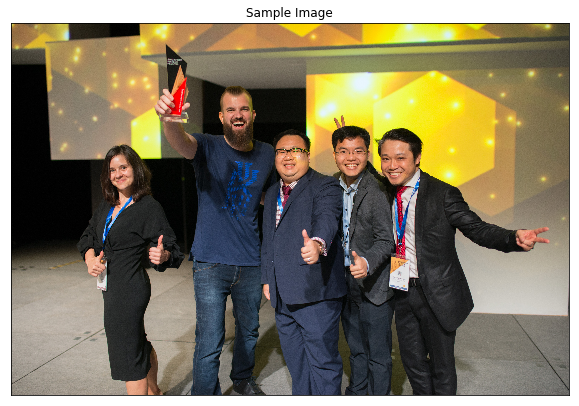

In [8]:
file_path = os.path.join(photo_dir, '2017', '2017.11.16 - Singapore Fintech Festival', '20171116-1923.jpg')
display_from_file(file_path)

The above is a group photo with 5 people. As mentioned earlier, this project focuses on face only. So the next step will be extracting the 5 faces and save them as 5 different image files with 299 \* 299 pixels.

#### Detect Faces, Save as New Files

There are many supporting functions and `process_faces()` is the one with many flags to represent whether need to display or save the given image file.

In [11]:
# pathlib available from python 3.5
from pathlib import Path
def get_faces(image, scaleFactor, minNeighb):
    """Perform face detection and return the detected faces as a list of (x,y,w,h).
    Args:
        image (numpy.ndarray): The numpay array of an image.
        scaleFactor (float): The scaling factor to be used by the detectMultiScale() function.
        minNeighb (int): The number of minimum neighbors to be used by the detectMultiScale() function.
    Returns:
        faces (list of tuples): The list of the face locations.
    """
    # Convert to RGB then to grayscale
    image = np.copy(image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # Extract the pre-trained face detector from an xml file
    face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
    # Detect the faces in image
    faces = face_cascade.detectMultiScale(gray, scaleFactor, minNeighb)
    return faces
        
def draw_bounding_box(image, faces):
    """Draw the bounding box of faces on the image.
    Args:
        image (np.ndarray): Numpy array of the image.
        faces (list of tuples): The list of the face locations.
    Return:
        image_with_detections (np.ndarray): A image with bounding box on faces, in numpy array format,
            after converting to RGB.
        image_faces (list[np.ndarray]): List of face images.
    """
    # Use np.copy() to create duplicate images to avoid aleration of the original image.
    image_copy = np.copy(image)
    image_with_detections = np.copy(image)
    image_copy = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    image_with_detections = cv2.cvtColor(image_with_detections, cv2.COLOR_BGR2RGB)
    # The list of detected faces
    image_faces = []
    # Get the bounding box for each detected face
    for (x,y,w,h) in faces:
        # Add a red bounding box to the detections image
        if w > 200:
            line_width = w//20
        else:
            line_width = 3
        image_faces.append(image_copy[y:(y+h), x:(x+w)])
        cv2.rectangle(image_with_detections, (x,y), (x+w,y+h), (255,0,0), line_width)
    return image_with_detections, image_faces

def create_get_target_dir_file(file_path):
    """Create the target directory if it's not existent, return the target directory as string
    Args:
        None: Global variables.
    Returns:
        target_dir (str): The address of the target directory.
    """
    # Create the full path of the target images by replacing the photo_dir string into target_image_dir string.
    target_file = file_path.replace(photo_dir, target_image_dir)
    target_dir = os.path.dirname(target_file)
    target_path = Path(target_dir)
    
    # Create parents of directory, don't raise exception if the directory exists
    target_path.mkdir(parents=True, exist_ok=True)
    return target_dir, target_file

def save_faces(file_path, image_faces):
    """Save each face image into new files in target_iamge_dir.
    Args:
        file_path (str): The full path of the original photo.
        image_faces (list[np.ndarray]): The list of face images, in numpy array format.
    Returns:
        None
    """
    if len(image_faces) == 0:
        return
    
    target_dir, target_file = create_get_target_dir_file(file_path)
    
    # Resize and save each face image.
    for i, face in enumerate(image_faces):
        face = cv2.resize(face, (299, 299))
        os.chdir(target_dir)
        file_name = os.path.basename(target_file)
        cv2.imwrite(file_name + '-face-' + str(i) + '.jpg', cv2.cvtColor(face, cv2.COLOR_BGR2RGB))
        print(os.path.join(target_dir, file_name + '-face-' + str(i) + '.jpg'), 'saved.')
        
def process_faces(file_path, display=NODISPLAY, save=NOSAVE, scaleFactor=1.3, minNeighb=5):
    """Process the input image file by extracting face(s). Display and save based on the flags.
    Args:
        file_path (str): The full path of the input image file.
        display (bool): Default is NODISPLAY/False.
        save (bool): Default is NOSAVE/False.
        scaleFactor (float): The scaling factor used by face detection function.
        minNeighb (int): The number of minimum neighbors.
    Returns:
        None: Perform display or save actions based on the flags.
    """
    print('Image path', file_path)
    image = get_numpy_from_file(file_path)
    faces = get_faces(image, scaleFactor, minNeighb)
    print('Number of faces detected:', len(faces))

    image_with_detections, image_faces = draw_bounding_box(image, faces)
    
    if save:
        save_faces(file_path, image_faces)

    if display:
        # Display the image with the detections
        display_from_numpy(image_with_detections)
        
    # Return to this project's current working directory
    os.chdir(cur_dir)

Image path D:\Pictures\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg
Image numpy array shape: (4760, 7132, 3) <class 'numpy.ndarray'>
Number of faces detected: 5
D:\Google Drive\Study\Machine Learning Engineer Nanodegree - Udacity\Projects\MLND-Projects\projects\facial_recognition_family_members\images\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg-face-0.jpg saved.
D:\Google Drive\Study\Machine Learning Engineer Nanodegree - Udacity\Projects\MLND-Projects\projects\facial_recognition_family_members\images\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg-face-1.jpg saved.
D:\Google Drive\Study\Machine Learning Engineer Nanodegree - Udacity\Projects\MLND-Projects\projects\facial_recognition_family_members\images\2017\2017.11.16 - Singapore Fintech Festival\20171116-1923.jpg-face-2.jpg saved.
D:\Google Drive\Study\Machine Learning Engineer Nanodegree - Udacity\Projects\MLND-Projects\projects\facial_recognition_family_members\images\2017\2017.

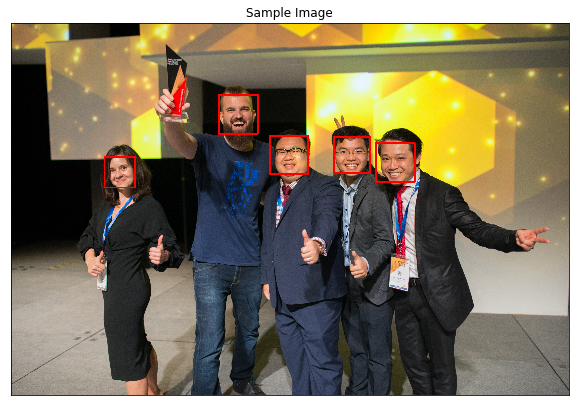

In [10]:
# Load in color image for face detection
file_path = os.path.join(photo_dir, '2017\\2017.11.16 - Singapore Fintech Festival', '20171116-1923.jpg')
process_faces(file_path, DISPLAY, SAVE)

#### Show the Saved Faces

In [12]:
def get_file_path_from_folder(folder_addr):
    """Return all jpg files' full paths as a list.
    Args:
        folder_add (str): The folder address.
    Returns:
        all_jpg (list): A list of strings which are the full path of jpg files.
    """
    all_jpg = []
    for root, dirs, files in os.walk(folder_addr):
        for file in files:
            if file[-3:].lower() == 'jpg':
                #print(len(path) * '---', file)
                all_jpg.append(os.path.join(root, file))
    return all_jpg

def get_numpy_from_folder(folder_addr):
    """Return all jpg files in a folder as numpy arrays.
    Args:
        folder_addr (str): The folder address.
    Returns:
        image_numpys (list[numpy.ndarrays]): The list of numpy arrays of jpg images in a folder.
    """
    all_jpg_addr = get_file_path_from_folder(folder_addr)
    image_numpys = []
    for jpg_addr in all_jpg_addr:
        image = get_numpy_from_file(jpg_addr)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_numpys.append(image)
    return image_numpys

Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>


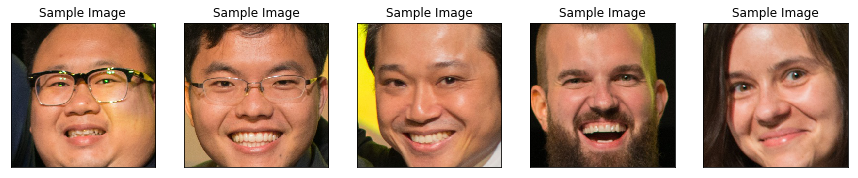

In [12]:
image_numpys = get_numpy_from_folder(os.path.join(cur_dir, 'images\\2017\\2017.11.16 - Singapore Fintech Festival'))
display_from_numpy(image_numpys, fig_dim_x=15, fig_dim_y=5, plot_nrows=1, plot_ncols=5)

### Batch Process Images and Extract Faces

In the earlier section, all the 40k image full pathes were store in `all_jpg` variable. So just need to be patient to wait for the results, it'll take quite several hours to finish.

In [ ]:
#############################
### RUN WITH CAUSION#########
#############################

# Scan through all 40k photos and extract faces
start = time.time()
for i in range(len(all_jpg)):
    process_faces(all_jpg[i], NODISPLAY, SAVE)
end = time.time()

In [13]:
def get_count_files(folder_addr):
    n = 0
    for root, dirs, files in os.walk(folder_addr):
        for file in files:
            n = n + 1
    return n

In [98]:
print('Extracting faces took %s hours' % round((end-start)/3600, 1))
print(get_count_files('images'), 'face images extracted')

Extracting faces took 13.2 hours
98059 face images extracted


About 13 hours has been taken and around 100k face images were generated.

Below sample images are from one folder. It's quite clear that the openCV is not 100% reliable, some of the photos are not face images.

Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.nd

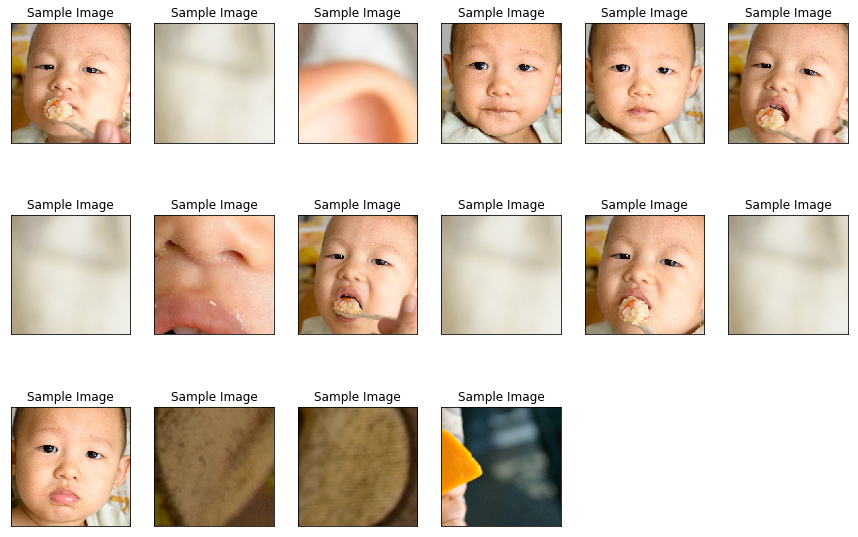

In [97]:
image_numpys = get_numpy_from_folder(os.path.join('images', '2017', '2017.10.25 - 祺祺吃饭'))
display_from_numpy(image_numpys, fig_dim_x=15, fig_dim_y=10, plot_nrows=3, plot_ncols=6)

### Manully Label the Face Images by Putting Them Into Different Folders
There are almost 100k faces extracted. Most of them are ir-relevant, and many of them are objects other than faces. I hand picked about 500 of the face images and saved them into 7 categories/folders.

In [14]:
categories = os.listdir('./images')
face_jpgs = get_file_path_from_folder('./images/')
print('Categories:', categories)
print('Total number of images:', len(face_jpgs))

Categories: ['Brother', 'Dad', 'Daughter', 'Me', 'Mum', 'Son', 'Wife']
Total number of images: 419


Below are some high level statistics about how many images in each category.

In [15]:
def count_each_category(categories, files):
    """Count the number of file for each category.
    Args:
        categories (list): A list of categories.
        files (list[str]): A list of strings which are the relative address of face images.
    Returns:
        stats_dict (dict): A dictionary of (category: number).
    """
    stats_dict = {}
    # Initilize the dictionary.
    for category in categories:
        stats_dict[category] = 0
    # Increment the value of the matching item.
    for file in files:
        # Convert the path string into Path object.
        file_path = Path(file)
        # str(file_path.parent) will return 'images\Brother', need to us os.sep as the delimiter
        # for cross platform use.
        file_category = str(file_path.parent).split(os.sep)[1]
        stats_dict[file_category] += 1
    return stats_dict

In [16]:
stats_dict = count_each_category(categories, face_jpgs)
print(stats_dict)

{'Wife': 72, 'Mum': 42, 'Dad': 38, 'Daughter': 90, 'Son': 73, 'Brother': 41, 'Me': 63}


Below bar plot shows the distribution of samples for each category. 'Daughter' category has the most images, 92. 'Son' has the second most, 73, so on and so forth. The distribution of samples are not well balanced. This observation will lead to few special 'treatment' in the later sections.

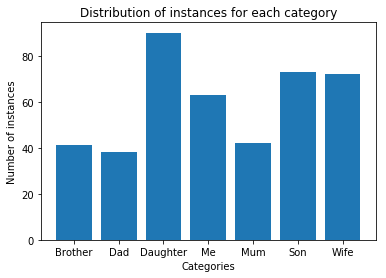

In [17]:
import matplotlib.pyplot as plt                        
%matplotlib inline
plt.bar(stats_dict.keys(), stats_dict.values())
plt.xlabel('Categories')
plt.ylabel('Number of instances')
plt.title('Distribution of instances for each category')
plt.show()

### Loading the Images and Split Them into Train, Validate and Test Datasets

In [18]:
# Function to load the images as a list of file names and one hot code categories
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from glob import glob

# Read all the files and return 2 numpy arrays.
# One is the address of the files and the other one is the one hot encode of the category.
def load_dataset(folder_addr):
    """Load all the files in the given directory. The name of each subdirectory will be the category name.
    Args:
        folder_addr (str): The folder address in which there are subfolders.
    Returns:
        face_files (list[str]): A list of face file address strings.
        face_targets (numpy.ndarray): Numpy array of categories, value from 0 to 6, without one-hot encoding.
    """
    data = load_files(folder_addr)
    face_files = np.array(data['filenames'])
#     face_targets = np_utils.to_categorical(np.array(data['target']), 7)
    face_targets = data['target']
    return face_files, face_targets

In [19]:
# Load the list of images and categories
faces, targets = load_dataset('./images')
face_names = [item[9:-1] for item in glob('./images/*/')]
print('There are %d face categories.' % len(face_names))
print(face_names)
print('There are %d total faces.' % len(faces))
print(count_each_category(categories, faces))

There are 7 face categories.
['Brother', 'Dad', 'Daughter', 'Me', 'Mum', 'Son', 'Wife']
There are 419 total faces.
{'Wife': 72, 'Mum': 42, 'Dad': 38, 'Daughter': 90, 'Son': 73, 'Brother': 41, 'Me': 63}


A random check on the file name and category name.

In [20]:
def parse_image_category(file_addr, category_code, is_one_hot=False):
    """Given the category in index or one-hot code, return the index and name of the category of an image.
    Args:
        file_addr (str): The address of the image whose name contains the category name.
        category_code (int or numpy.nparray): Integer index of the category or numpy array after one-hot encoding.
        is_one_hot (bool): Default it's False, set to True if the passed in category_code is in one-hot format.
    Returns:
        category_index (int): The index of the category, from 0 to 6.
        face_names[category_index] (str): The name of the category.
    """
    # Print file path and category in one hot code
    print(file_addr, category_code)
    if is_one_hot:
        category_index = np.argmax(category_code)
    else:
        category_index = category_code
    return category_index, face_names[category_index]

parse_image_category(faces[100], targets[100])

./images\Dad\20160701-1737.jpg-face-0.jpg 1


(1, 'Dad')

From this point, the data set is finally ready for the coming machine learning piplines.

## III. Methodology and Implementation
### Algorithms and Techniques

The input image is with size of 299 \* 299 pixels, 3 channels for a color pixel, that's a space with almost 270k dimensions. It's too big to be processed directly by the machine learning algorithms. Hence, Google Inception V3 will be applied first to extract the feature vectors with dimensionality of 2048. Maybe it's still too big in this project but we'll see.

A linear classifier will be applied first. Its performance will be used as the baseline of the benchmark model. Subsequently, KNN, Logistic Regression and Deep Learning models will be applied and measured against the linear classifier.

As shown in the earlier section, around 500 images were chosen and number of samples for each category is not so balanced. Despite Google Inception V3 helped eliminate the necessity of having many samples for image recognition, it's still possible that my dataset is too small. So if it's needed, techniques like using [image generator](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) will be explored in this project.

### Extract Feature Vectors

In [21]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Input
from keras import backend as K
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from keras.callbacks import ModelCheckpoint, EarlyStopping, LambdaCallback, ReduceLROnPlateau
from keras.models import load_model
from keras.preprocessing import image

In [22]:
def path_to_tensor(img_path):
    """Given one image path, return it as a numpy array.
    Args:
        img_path (str): The full path string of a image.
    Returns:
        np.expand_dims(x, axis=0) (numpy.ndarray): A 4D numpy array of a image after expanding from 3D to 4D.
    """
    img = image.load_img(img_path, target_size=(299,299))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    """Given the image paths, return them as a vertically stacked numpy array.
    Args:
        img_paths (list[str]): The full paths of the images in a list.
    Returns:
        np.vstack(list_of_tensors) (numpy.ndarray): 4D numpy array of all the images, after normalization.
    """
    list_of_tensors = [path_to_tensor(img_path) for img_path in img_paths]
    return np.vstack(list_of_tensors).astype('float32')/255

In [23]:
# Load the inception v3 model, include the dense layers
base_model = InceptionV3(weights='imagenet', include_top=True)
vector_out = base_model.get_layer('avg_pool')
feature_model = Model(inputs=base_model.input, outputs=vector_out.output)

In [24]:
def get_features(feature_model, tensors):
    """Using the given model to convert a tensor/image to a feature vector
    Args:
        feature_model (Keras Model): In this project, it's the Google Inception V3 model without the last dense layer.
        tensors (numpy.ndarray): Group of images in a 4D numpy array.
    Returns:
        feature_outputs (numpy.ndarray): Feature vectors of the group of images, dimension of (x, 2018)
    """
    tensor_inputs = np.expand_dims(tensors, axis=0)
    feature_outputs = feature_model.predict(tensors)
    return feature_outputs

Split the dataset into train, validate and test datasets. The data are not well balanced based on the earlier bar plot diagram. Hence, straitified split function will be used here.

In [25]:
train_faces, test_faces, train_targets, test_targets = train_test_split(faces, targets, test_size=0.15, random_state=1, stratify=targets)
train_faces, validate_faces, train_targets, validate_targets = train_test_split(train_faces, train_targets, test_size=0.2, random_state=1, stratify=train_targets)
print('There are %d training faces.' % len(train_faces))
print(count_each_category(categories, train_faces))
print('There are %d validate faces.' % len(validate_faces))
print(count_each_category(categories, validate_faces))
print('There are %d test faces.' % len(test_faces))
print(count_each_category(categories, test_faces))

There are 284 training faces.
{'Wife': 49, 'Mum': 29, 'Dad': 25, 'Daughter': 61, 'Son': 49, 'Brother': 28, 'Me': 43}
There are 72 validate faces.
{'Wife': 12, 'Mum': 7, 'Dad': 7, 'Daughter': 15, 'Son': 13, 'Brother': 7, 'Me': 11}
There are 63 test faces.
{'Wife': 11, 'Mum': 6, 'Dad': 6, 'Daughter': 14, 'Son': 11, 'Brother': 6, 'Me': 9}


In [26]:
# Read the images as numpy arrays
train_tensors = paths_to_tensor(train_faces)
test_tensors = paths_to_tensor(test_faces)
validate_tensors = paths_to_tensor(validate_faces)
print("Train tensor shape.", train_tensors.shape)
print('Test tensor shape.', test_tensors.shape)
print('Validate tensor shape.', validate_tensors.shape)

Train tensor shape. (284, 299, 299, 3)
Test tensor shape. (63, 299, 299, 3)
Validate tensor shape. (72, 299, 299, 3)


In [27]:
train_features = get_features(feature_model, train_tensors)
validate_features = get_features(feature_model, validate_tensors)
test_features = get_features(feature_model, test_tensors)
print('Train features shape:', train_features.shape, '\nValidate feature_modelres shape: ', validate_features.shape,
      '\nTest features shape:', test_features.shape)

Train features shape: (284, 2048) 
Validate feature_modelres shape:  (72, 2048) 
Test features shape: (63, 2048)


### Attempt to Train and Test on Various Models
'Traditional' machine learning models of SGDClassifier, LogistricRegression, KNeighborsClassifier will be explored first. Then followed by deep neural network.

In [28]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
clf_sgd = SGDClassifier(random_state=0)
clf_knn = KNeighborsClassifier(n_neighbors=7)
clf_log = LogisticRegression(random_state=0)

In [29]:
%time model_sgd = clf_sgd.fit(train_features, train_targets)
%time model_knn = clf_knn.fit(train_features, train_targets)
%time model_log = clf_log.fit(train_features, train_targets)

C:\Users\Xiaowei\Anaconda3\envs\tfkeras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Wall time: 51 ms
Wall time: 38 ms
Wall time: 838 ms


In [101]:
start = time.time()
%time predict_test_sgd = model_sgd.predict(test_features)
%time predict_test_knn = model_knn.predict(test_features)
%time predict_test_log = model_log.predict(test_features)
end = time.time()
print('%.2gs' %(end - start))

Wall time: 4 ms
Wall time: 76.1 ms
Wall time: 1 ms
0.085s


Due to the imbalanced data as mentioned earlier, the average of precision, recall and fbeta score will be set as `weighted`.

In [132]:
from sklearn.metrics import fbeta_score, precision_recall_fscore_support, confusion_matrix
import pandas as pd
def get_score_numpy(test_targets, predict_targets, average = 'weighted'):
    score = precision_recall_fscore_support(test_targets, predict_targets, average=average)
    score = np.array(score)
    score = score[score != None]
    return score

In [145]:
score_sgd = get_score_numpy(test_targets, predict_test_sgd)
score_knn = get_score_numpy(test_targets, predict_test_knn)
score_log = get_score_numpy(test_targets, predict_test_log)

In [146]:
data = pd.DataFrame(np.stack((score_sgd, score_knn, score_log)),
                    columns=['Precision', 'Recall', 'F1'], index=['SGD', 'KNN', 'Log'])
data

Precision    Recall        F1
SGD  0.792347  0.777778  0.775751
KNN  0.717082   0.68254  0.683151
Log  0.826874  0.793651   0.78914

Based on above table, logsitic regression performed the best based on every angel of precision, recall and f1 scores. It is fast on testing but not training.

Below confusion matrix plots provide more intuitive ways of how good or bad the logistic regression model is doing for each label. The first plot is based on the absolute number of samples. The second plot is after normalization, which shows a more accurate estimation.

In [148]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
        pass
#         print('Confusion matrix, without normalization')

#     print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

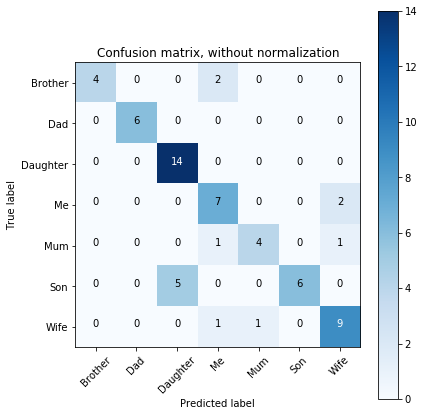

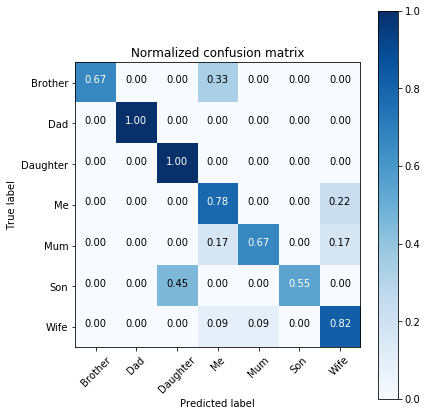

In [166]:
cnf_matrix = confusion_matrix(test_targets, predict_test_log)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=face_names, title='Confusion matrix, without normalization')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=face_names, normalize=True, title='Normalized confusion matrix')
plt.show()

So far all the chosen models performed training and prediction in fractions of a second. The best accuracy is about 80% from logistic regression while KNN only got the lowest 68%, even though it's much better than random guess of 1/7 = 16.7%. Below is an exploration on using DNN model.

In [33]:
Inp = Input(shape=(2048,))
x = Dense(300, activation='relu')(Inp)
x = Dense(50, activation='relu')(x)
output = Dense(7, activation='softmax')(x)
model_dnn = Model(inputs=Inp, outputs=output)
model_dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 300)               614700    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                15050     
_________________________________________________________________
dense_3 (Dense)              (None, 7)                 357       
Total params: 630,107
Trainable params: 630,107
Non-trainable params: 0
_________________________________________________________________


As a classification problem, deep learning models will require the output in one-hot format.

In [34]:
train_targets_one_hot = np_utils.to_categorical(train_targets)
validate_targets_one_hot = np_utils.to_categorical(validate_targets)
test_targets_one_hot = np_utils.to_categorical(test_targets)

In [35]:
model_dnn.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model_dnn.save_weights('init_weights.h5')
checkpointer = ModelCheckpoint(filepath='model_dnn.h5', verbose=1, save_best_only=True)

In [33]:
%%time
model_dnn.load_weights('init_weights.h5')
hist_1 = model_dnn.fit(train_features, train_targets_one_hot,
            validation_data=(validate_features, validate_targets_one_hot),
            epochs=50, verbose=1, batch_size=20,
            callbacks=[checkpointer])

Train on 284 samples, validate on 72 samples
Epoch 1/50
284/284 [==============================] - 0s - loss: 1.9837 - acc: 0.2923 - val_loss: 1.6453 - val_acc: 0.4167
Epoch 2/50
284/284 [==============================] - 0s - loss: 1.3760 - acc: 0.4577 - val_loss: 1.3206 - val_acc: 0.3611
Epoch 3/50
284/284 [==============================] - 0s - loss: 1.1602 - acc: 0.5176 - val_loss: 1.4567 - val_acc: 0.4444
Epoch 4/50
284/284 [==============================] - 0s - loss: 0.9435 - acc: 0.6232 - val_loss: 1.1507 - val_acc: 0.4861
Epoch 5/50
284/284 [==============================] - 0s - loss: 0.7795 - acc: 0.7042 - val_loss: 1.1881 - val_acc: 0.5417
Epoch 6/50
284/284 [==============================] - 0s - loss: 0.6895 - acc: 0.7570 - val_loss: 0.8954 - val_acc: 0.5833
Epoch 7/50
284/284 [==============================] - 0s - loss: 0.5816 - acc: 0.8099 - val_loss: 0.9426 - val_acc: 0.5972
Epoch 8/50
284/284 [==============================] - 0s - loss: 0.4561 - acc: 0.8556 - val_lo

In [34]:
## TODO: Visualize the training and validation loss of your neural network
import matplotlib.pyplot as plt
def plt_hist(hist):
    print(hist.history.keys())
    # summarize history for accuracy
    plt.plot(hist.history['acc'])
    plt.plot(hist.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

dict_keys(['val_loss', 'acc', 'loss', 'val_acc'])


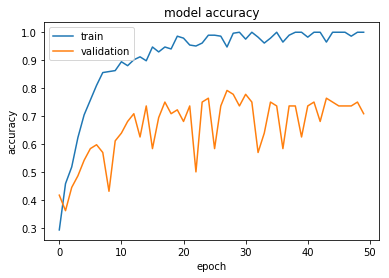

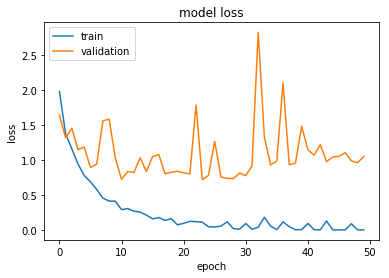

In [35]:
plt_hist(hist_1)

Epoch of 50 looks like a reasonable number of iterations. The validation accuracy is stable and the loss is starting to grow, that's a sign of overfitting. Techniques of reducing learning rate, early stopping could be further explored, but not covered in this project.

Below is the metrics of the DNN model.

In [186]:
model_dnn = load_model('./model_dnn.h5')
%time predict_test_dnn = model_dnn.predict(test_features)
predict_test_dnn = predict_test_dnn.argmax(axis=-1)
print('Precision, Recall, F1')
print(get_score_numpy(test_targets, predict_test_dnn))

Wall time: 217 ms
Precision, Recall, F1
[0.80839002267573701 0.76190476190476186 0.74800304365521764]


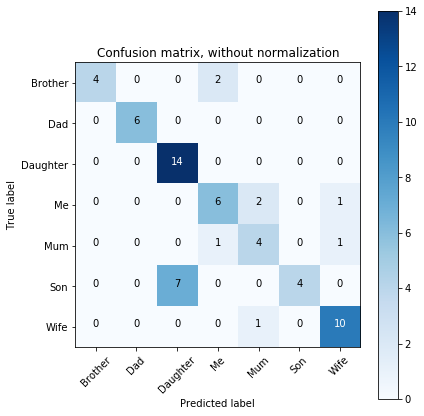

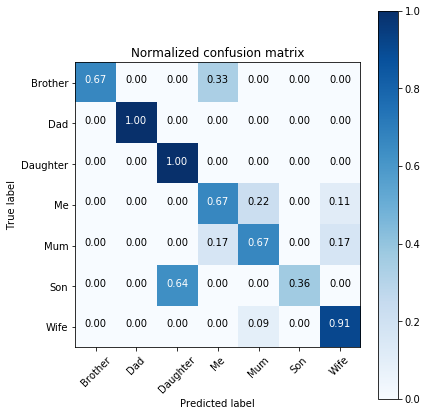

In [187]:
cnf_matrix = confusion_matrix(test_targets, predict_test_dnn)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=face_names, title='Confusion matrix, without normalization')
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=face_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Based on the current split of the dataset, logistic regression performed the best. KNN reached merely 70% while SGD classifier, logistic regression and DNN reached accuracy of 75% to 80%. DNN took significant longer time on training, as well as prediction. 

But what if it's just a coincidence, what if I had more images? The next section will look into the refinement of the models from two ways.

The first one is to use image generator to have a bigger dataset. The other one will focus on using cross validation to determine the best model.

## IV. Refinement

### Create More images
Use [image generator](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) to create more images. This is a very useful technique when having little data.

In this project, I put the new images in folder `images2` and 10 new images will be generated for each original image.

In [36]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import shutil

datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

def get_target_dir(face_file):
    """ Given the address of the original image, create directory for the new generated images if needed.
        Also return the new directory address.
    Args:
        face_file (str): The address of the original face file, may or may not be in full address.
    Returns:
        target_dir (str): The address of the directory for the generated images.
    """
    target_file = face_file.replace('images', 'images2')
    target_dir = os.path.dirname(target_file)
    target_path = Path(target_dir)
    
    # Create parents of directory, don't raise exception if the directory exists
    target_path.mkdir(parents=True, exist_ok=True)
    return target_dir

def generate_images(faces):
    """ Given the address of face images, use image generator to generate new images.
    Args:
        faces ([str]): The list of face images addresses.
    Returns:
        None: Generate new images and return None.
    """
    if os.path.exists('images2'):
        shutil.rmtree('images2', ignore_errors=True)
        # sleep for 2 seconds to allow OS finish the previous deletion action.
        time.sleep(2)
    for n, face in enumerate(faces):
        if n % 100 == 0:
            print('Generating images, ' + str(n) + ' of ' + str(len(faces)) + ' faces')
        target_dir = get_target_dir(face)

        img = load_img(face)
        x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

        # the .flow() command below generates batches of randomly transformed images
        # and saves the results to the target directory
        i = 0
        for batch in datagen.flow(x, batch_size=1, save_to_dir=target_dir, save_prefix='gen', save_format='jpg'):
            i += 1
            if i > 10:
                break  # otherwise the generator would loop indefinitely

Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>
Image numpy array shape: (299, 299, 3) <class 'numpy.ndarray'>


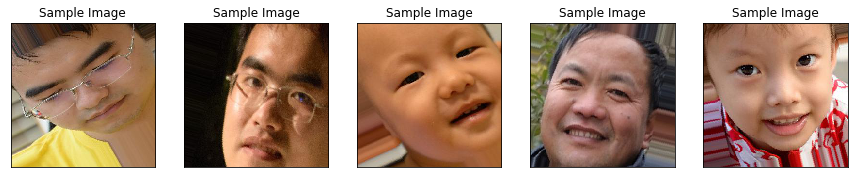

In [37]:
image_numpys = get_numpy_from_folder('sample_generated')
display_from_numpy(image_numpys, fig_dim_x=15, fig_dim_y=5, plot_nrows=1, plot_ncols=5)

### With Straitified K-fold CV
For a more 'stable' performance of each model, K-fold CV will be used in this project. So that each and every image will have the chance to be used for both training and testing. In this way, we will have more 'averaged' and thus more 'stable' performance evaluation.

In [38]:
from sklearn.model_selection import StratifiedKFold
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits)
skf.get_n_splits(faces, targets)

10

In [39]:
def perform_training(clf, features, targets):
    ''' Perform training, return the trained model and time taken in seconds.
    Args:
        clf (sklearn-model): The sklearn model.
        features (numpy.array): Training input, 4D numpy array.
        targets (numpy.array): Training output, 1D numpy array.
    Returns:
        model (sklean-model): The trained model.
        end - start: Time taken, in seconds.
    '''
    start = time.time()
    model = clf.fit(features, targets)
    end = time.time()
    return model, round(end - start, 3)

def perform_testing(model, features, targets):
    ''' Perform testing, return the accuracy and time taken in seconds.
    Args:
        model (sklearn-model): The sklearn model.
        features (numpy.array): Testing input, 4D numpy array.
        targets (numpy.array): Testing output, 1D numpy array.
    Returns:
        accuracy: The accuracy score.
        end - start: Time taken, in seconds.
    '''
    start = time.time()
    predictions = model.predict(features)
    end = time.time()
    accuracy = accuracy_score(targets, predictions)
    return round(accuracy, 3), round(end - start, 3)

def perform_dnn_training(model, features, targets):
    ''' Perform training, return the trained model and time taken in seconds.
    Args:
        clf (sklearn-model): The sklearn model.
        features (numpy.array): Training input, 4D numpy array.
        targets (numpy.array): Training output, 1D numpy array.
    Returns:
        model (sklean-model): The trained model.
        end - start: Time taken, in seconds.
    '''
    targets = np_utils.to_categorical(targets)
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    model.fit(features, targets, epochs=50, verbose=0, batch_size=20)
    end = time.time()
    return model, round(end - start, 3)

def perform_dnn_testing(model, features, targets):
    ''' Perform testing, return the accuracy and time taken in seconds.
    Args:
        model (keras.model): The keras model
        features (numpy.array): Testing input, 4D numpy array.
        targets (numpy.array): Testing output, 1D numpy array.
    Returns:
        accuracy: The accuracy score.
        end - start: Time taken, in seconds.
    '''
    targets = np_utils.to_categorical(targets)
    start = time.time()
    accuracy = model.evaluate(features, targets, verbose=0)[1]
    end = time.time()
    return round(accuracy, 3), round(end - start, 3)

In [44]:
all_accuracies = []
all_train_times = []
all_test_times = []
n = 0
for train_index, test_index in skf.split(faces, targets):
    n = n + 1
    print('Round ' + str(n) + ' of ' + str(n_splits))
    x_train, x_test = faces[train_index], faces[test_index]
    y_train, y_test = targets[train_index], targets[test_index]
    
    generate_images(x_train)
    # After generating the images, reaload the training dataset, testing dataset remains the same
    x_train, y_train = load_dataset('./images2')
    face_names = [item[10:-1] for item in glob('./images2/*/')]
    
    x_train_tensors = paths_to_tensor(x_train)
    x_test_tensors = paths_to_tensor(x_test)
    x_train_features = get_features(feature_model, x_train_tensors)
    x_test_features = get_features(feature_model, x_test_tensors)
    
    # Define and initialize models.
    clf_sgd = SGDClassifier(random_state=0)
    clf_knn = KNeighborsClassifier(n_neighbors=7)
    clf_log = LogisticRegression(random_state=0)
    accuracies = []
    train_times = []
    test_times = []
    for clf in [clf_sgd, clf_knn, clf_log]:
        model, train_time = perform_training(clf, x_train_features, y_train)
        accuracy, test_time = perform_testing(model, x_test_features, y_test)
        accuracies.append(accuracy)
        train_times.append(train_time)
        test_times.append(test_time)
    
    # DNN model must use this way to 're-initialize' the weights. The 'init_weights.h5' was
    # created in the earlier section for the first try of DNN.
    model_dnn.load_weights('init_weights.h5')
    model_dnn, train_time = perform_dnn_training(model_dnn, x_train_features, y_train)
    accuracy, test_time = perform_dnn_testing(model_dnn, x_test_features, y_test)
    accuracies.append(accuracy)
    train_times.append(train_time)
    test_times.append(test_time)
    
    all_accuracies.append(accuracies)
    all_train_times.append(train_times)
    all_test_times.append(test_times)

Round 1 of 10
Generating images, 0 of 373 faces
Generating images, 100 of 373 faces
Generating images, 200 of 373 faces
Generating images, 300 of 373 faces


C:\Users\Xiaowei\Anaconda3\envs\tfkeras\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


Round 2 of 10
Generating images, 0 of 374 faces
Generating images, 100 of 374 faces
Generating images, 200 of 374 faces
Generating images, 300 of 374 faces
Round 3 of 10
Generating images, 0 of 376 faces
Generating images, 100 of 376 faces
Generating images, 200 of 376 faces
Generating images, 300 of 376 faces
Round 4 of 10
Generating images, 0 of 378 faces
Generating images, 100 of 378 faces
Generating images, 200 of 378 faces
Generating images, 300 of 378 faces
Round 5 of 10
Generating images, 0 of 378 faces
Generating images, 100 of 378 faces
Generating images, 200 of 378 faces
Generating images, 300 of 378 faces
Round 6 of 10
Generating images, 0 of 378 faces
Generating images, 100 of 378 faces
Generating images, 200 of 378 faces
Generating images, 300 of 378 faces
Round 7 of 10
Generating images, 0 of 378 faces
Generating images, 100 of 378 faces
Generating images, 200 of 378 faces
Generating images, 300 of 378 faces
Round 8 of 10
Generating images, 0 of 378 faces
Generating image

In [45]:
np_accuracies = np.vstack(all_accuracies)
np_train_times = np.vstack(all_train_times)
np_test_times = np.vstack(all_test_times)

In [46]:
print('Average accuracy of SGD, KNN, LogisticRegression, DNN')
print(np.mean(np_accuracies, axis=0))
print('Average training time of SGD, KNN, LogisticRegression, DNN (seconds)')
print(np.mean(np_train_times, axis=0))
print('Average testing time of SGD, KNN, LogisticRegression, DNN (seconds)')
print(np.mean(np_test_times, axis=0))

Average accuracy of SGD, KNN, LogisticRegression, DNN
[ 0.76    0.7187  0.8296  0.8112]
Average training time of SGD, KNN, LogisticRegression, DNN (seconds)
[  0.3246   0.793   13.7715  50.2346]
Average testing time of SGD, KNN, LogisticRegression, DNN (seconds)
[ 0.0007  0.524   0.0006  0.2073]


# V. Results

The linear model (SGDClassifier) is doing quite ok in the first try and refinement section. It is almost the fastest one on both training and testing. Surprisingly, KNN doesn't perform so well in terms of accuracy. I guess it's due to the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality#Nearest_neighbor_search).

Logistic regression and DNN do better job on accuracy but at the cost of longer training and testing time, especially for DNN model.

Below plot displays the accuracy, training and testing time of the 4 different models. And it's easy to derive above mentioned observations.

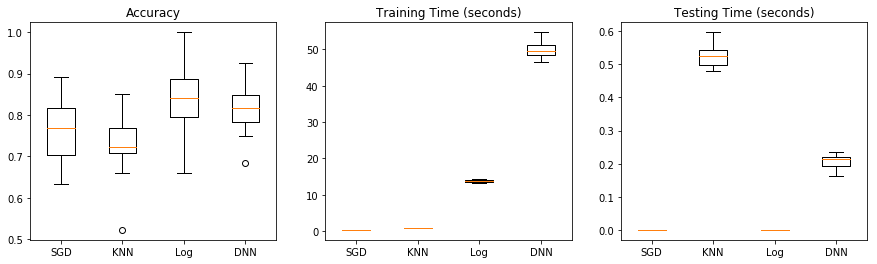

In [47]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(1, 3, 1)
ax.boxplot(np_accuracies)
ax.set_title('Accuracy')
ax.set_xticklabels(['SGD', 'KNN', 'Log', 'DNN'])

ax = fig.add_subplot(1, 3, 2)
ax.boxplot(np_train_times)
ax.set_title('Training Time (seconds)')
ax.set_xticklabels(['SGD', 'KNN', 'Log', 'DNN'])

ax = fig.add_subplot(1, 3, 3)
ax.boxplot(np_test_times)
ax.set_title('Testing Time (seconds)')
ax.set_xticklabels(['SGD', 'KNN', 'Log', 'DNN'])
plt.show()

# VI. Conclusion

Among all the 4 models, logistic regression is the one giving highest accuracy and also acceptable training and testing time.

The accuracy of logistic regression model is 5% to 10% higher than the other 3 models. The training time is longer than SGD classifier and KNN, but not as much longer as DNN. The testing time is very fast, and actually it's the fastest one.

80% was the best result for the first random try among the 4 models. Without any additional dataset needed, by just using the image generator, I was able to the push the accuracy higher by 5%. The final model has an average accuracy of 85%. This is achieved by using the Google Inception V3 model to extract the features from images and a very commonly used logistic regression model.

The DNN model in this project is exactly a transfer learning approach. Its accuracy is quite good, but it takes a long time to train and it's also costly. In this project I'm using GTX 1070 Ti, a GPU costs around USD 500. If the training is under the same CPU environment, I won't doubt it'll take at least 10 more times of current time.

# VII. Fun Part - in Real World
There are two family photos `test_1.jpg` and `test_2.jpg` in the root of working directory. Both of them were not used for training or testing in the earlier sections. Let's first perform a face detection using the `process_faces()`.

Image path ./test_1.jpg
Image numpy array shape: (4766, 7141, 3) <class 'numpy.ndarray'>
Number of faces detected: 4


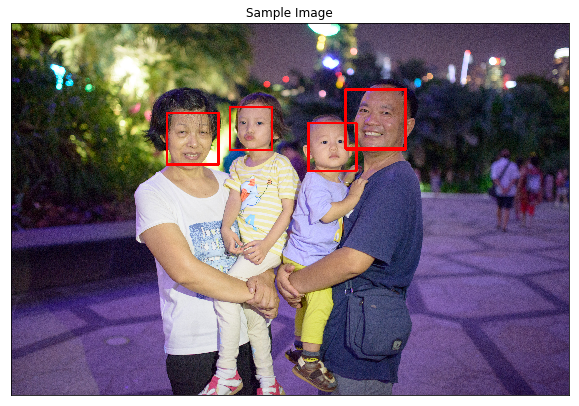

In [48]:
process_faces('./test_1.jpg', DISPLAY, NOSAVE, 1.35, 5)

Image path ./test_2.jpg
Image numpy array shape: (4912, 7360, 3) <class 'numpy.ndarray'>
Number of faces detected: 7


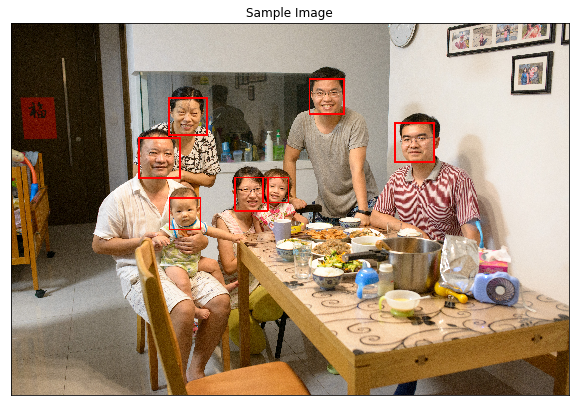

In [49]:
process_faces('./test_2.jpg', DISPLAY, NOSAVE, 1.32, 7)

Now we can train a logistic regression model by using the `./images2` dataset.

In [99]:
faces, _ = load_dataset('./images')
generate_images(faces)

Generating images, 0 of 419 faces
Generating images, 100 of 419 faces
Generating images, 200 of 419 faces
Generating images, 300 of 419 faces
Generating images, 400 of 419 faces


In [60]:
faces, targets = load_dataset('./images2')
all_train_tensors = paths_to_tensor(faces)
all_train_targets = targets
all_train_features = get_features(feature_model, all_train_tensors)

clf_log = LogisticRegression(random_state=0)
%time model_log = clf_log.fit(all_train_features, all_train_targets)

Wall time: 15.8 s


In [87]:
import pickle
pickle.dump(clf_log, open('clf_log', 'wb'))
clf_log = pickle.load(open('clf_log', 'rb'))

In [79]:
def get_name(model, image_face):
    ''' Use the model to make prediction and return the result as the name of the face.
    Args:
        model (sklearn.model): A trained model.
        image_face (numpy.array): A face image in 3D numpy array.
    Returns:
        face_names[predict_idx] (str): The name of the face.
    '''
    # Conver the 3 channel RGB to 4-d tensor and normalize it
    image_face_tensors = image_face.reshape(-1, 299, 299, 3)/255
    image_face_features = get_features(feature_model, image_face_tensors)
    predict_idx = model.predict(image_face_features)[0]
    return face_names[predict_idx]

def process_faces_names(file_path, scaleFactor=1.3, minNeighb=5):
    """Process the input image file by extracting face(s). Draw bounding box and detected name.
    Args:
        file_path (str): The full path of the input image file.
        scaleFactor (float): The scaling factor used by face detection function.
        minNeighb (int): The number of minimum neighbors.
    Returns:
        None: Display the image.t
    """
    print('Image path', file_path)
    image = get_numpy_from_file(file_path)
#     image = cv2.fastNlMeansDenoisingColored(image,None,5,5,7,15)
    faces = get_faces(image, scaleFactor, minNeighb)
    print('Number of faces detected:', len(faces))

    image_with_detections, image_faces = draw_bounding_box(image, faces)
    
    for i, (x,y,w,h) in enumerate(faces):
        cur_face = cv2.resize(image_faces[i], (299,299))
        name = get_name(model_log, cur_face)

        # Write the returned name on the image
        cv2.putText(image_with_detections, name,
                    (x,y-100),cv2.FONT_HERSHEY_SIMPLEX, 7, (255,0,0),20,cv2.LINE_AA)

    display_from_numpy(image_with_detections, 12, 12)

Image path ./test_1.jpg
Image numpy array shape: (4766, 7141, 3) <class 'numpy.ndarray'>
Number of faces detected: 4


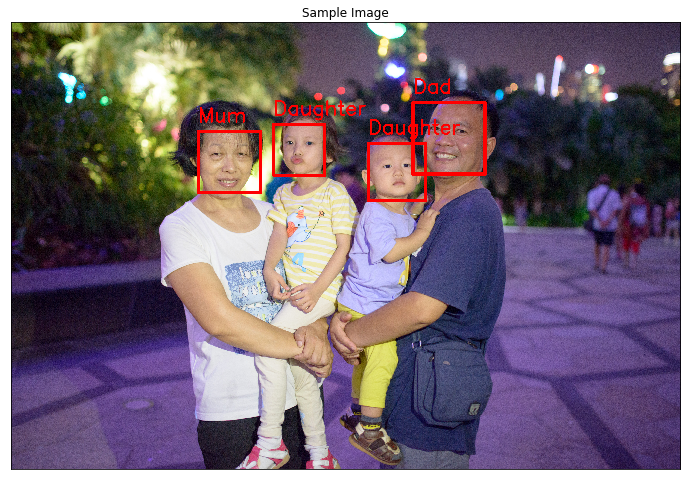

In [80]:
process_faces_names('./test_1.jpg', 1.35, 5)

Image path ./test_2.jpg
Image numpy array shape: (4912, 7360, 3) <class 'numpy.ndarray'>
Number of faces detected: 7


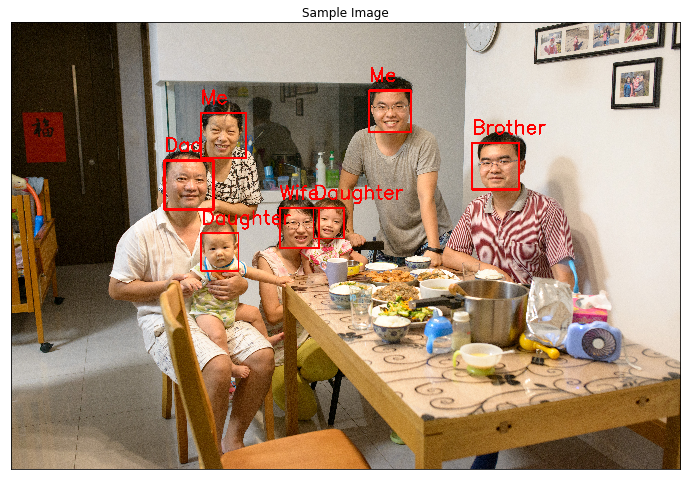

In [81]:
process_faces_names('./test_2.jpg', 1.32, 7)

The result is not perfect, both photos have misclassfied face(s). The accuracy is around 70%. Not good, but not too bad, because we are family and we are born to look similar. The most important thing is, it's super fun!